<a href="https://colab.research.google.com/github/lorihe/Springboard-Capstone3---Transfer_Learning/blob/colab/05_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras import callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
drive.mount('/content/drive')
%cd drive/MyDrive/Game_Classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Game_Classification


In [4]:
def img_Data(dir_path, target_size, batch, class_lst, preprocessing):
  """
    Create a data generator using ImageDataGenerator for loading and augmenting images from a directory.

    Args:
        dir_path (str): Path to the directory containing the image files organized in subdirectories.
        target_size (tuple): A tuple specifying the target height and width of the images.
        batch (int): The batch size for training or inference.
        class_lst (list): List of class names. Subdirectories in 'dir_path' should be named after these classes.
        preprocessing (function, optional): A function that is applied to each input image for preprocessing.
            This function should take an input image (either a PIL image or a Numpy array) and return a
            preprocessed Numpy array. Default is None.

    Returns:
        DirectoryIterator: A DirectoryIterator yielding batches of augmented/loaded image data along with labels.
  """
  if preprocessing:
    gen_object = ImageDataGenerator(preprocessing_function = preprocessing)
  else:
    gen_object = ImageDataGenerator()

  return(gen_object.flow_from_directory(dir_path, target_size, batch_size = batch, class_mode = 'sparse',
                                   classes = class_lst, shuffle = True))

In [5]:
image_classes = ['rugby', 'soccer']
image_exts =['JPEG', 'JPG', 'BMP', 'PNG', 'MPO']

In [6]:
# Check file format
NoneType = 0

for image_class in image_classes:
  for image in os.listdir(os.path.join('test_imgs', image_class)):
    image_path = os.path.join('test_imgs', image_class, image)
    try:
      with Image.open(image_path) as img:
        assert type(img) != None
        format = img.format
      if format not in image_exts:
        print('Format of {} is {}'.format(image_path, format))
    except Exception as e:
        print('Issue with image {}'.format(image_path))

In [7]:
# Load previously saved model
model = tf.keras.models.load_model("model.hdf5")

In [8]:
true_labels = []
predicted_labels = []
file_path = []

In [9]:
def load_and_preprocess_image(image_path):
    '''
    Load and preprocess an image from the specified path.

    Parameters:
    image_path (str): The file path to the image.

    Returns:
    numpy.ndarray: A preprocessed image as a NumPy array.
    '''
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
# Load images from rugby folder and predict with model
for image in os.listdir(os.path.join('test_imgs/rugby')):
    image_path = os.path.join('test_imgs/rugby', image)
    img = load_and_preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_label = np.argmax(predictions, axis=-1)
    file_path.append(image_path)
    true_labels.append("Rugby")
    predicted_labels.append("Rugby" if predicted_label == 0 else "Soccer")

In [ ]:
# Load images from soccer folder and predict with model
for image in os.listdir(os.path.join('test_imgs/soccer')):
    image_path = os.path.join('test_imgs/soccer', image)
    img = load_and_preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_label = np.argmax(predictions, axis=-1)
    file_path.append(image_path)
    true_labels.append("Soccer")
    predicted_labels.append("Rugby" if predicted_label == 0 else "Soccer")

In [12]:
matrix_df = pd.DataFrame({'True': true_labels, 'Predicted': predicted_labels, 'File': file_path})

In [13]:
matrix_df.head()

,True,Predicted,File
0,Rugby,Rugby,test_imgs/rugby/stock-photo-rugby-player-divin...
1,Rugby,Soccer,test_imgs/rugby/1200px-Fiji_Australia_Oktoberf...
2,Rugby,Rugby,test_imgs/rugby/istockphoto-1268222741-612x612...
3,Rugby,Soccer,test_imgs/rugby/istockphoto-1239474801-612x612...
4,Rugby,Soccer,test_imgs/rugby/istockphoto-1159627376-612x612...


In [14]:
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[38 12]
 [ 0 50]]

Classification Report:
              precision    recall  f1-score   support

       Rugby       1.00      0.76      0.86        50
      Soccer       0.81      1.00      0.89        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



In [15]:
predict_error = matrix_df[matrix_df['True'] != matrix_df['Predicted']]

In [16]:
predict_error['True'].value_counts()

Rugby    12
Name: True, dtype: int64

In [17]:
predict_error = predict_error.reset_index()

Wrongly labeled images


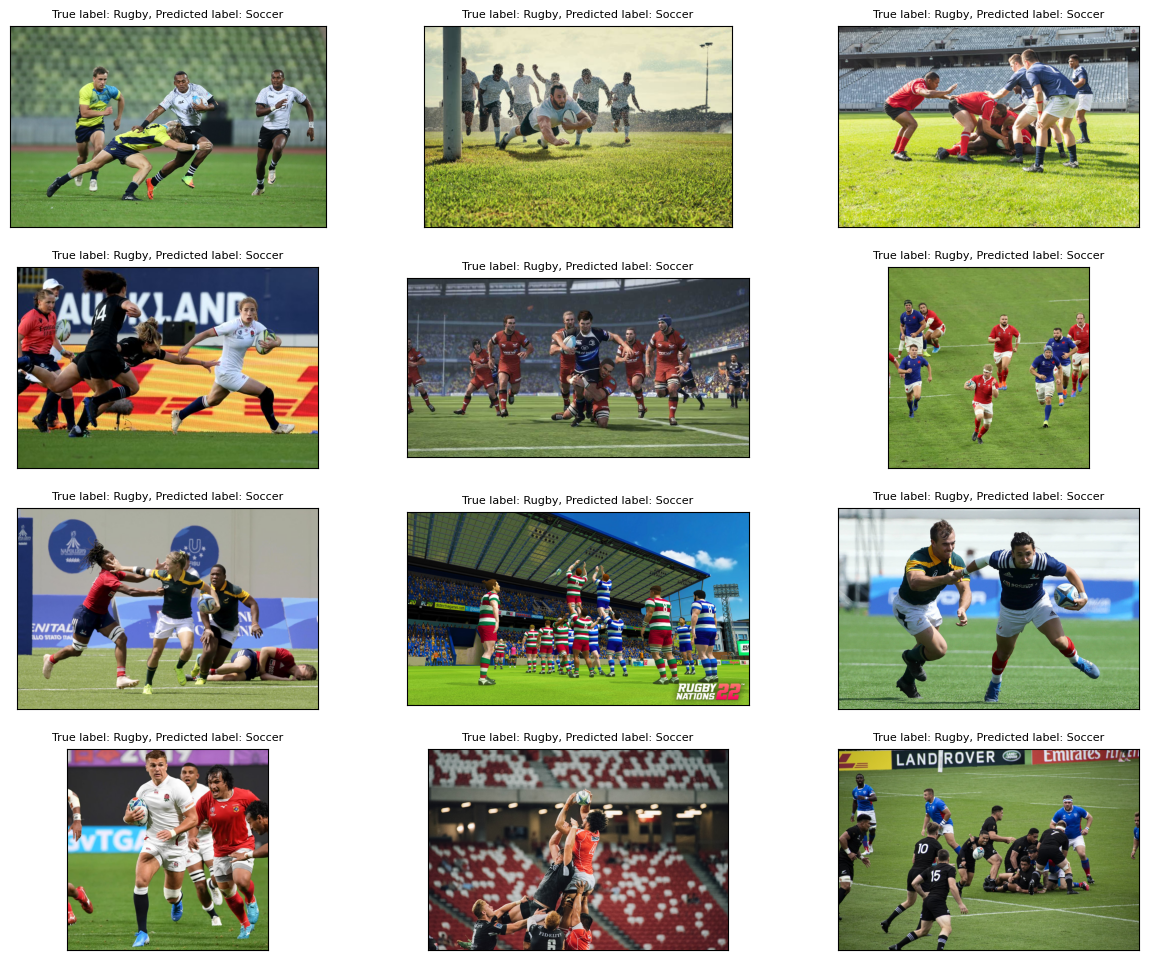

In [18]:
# Visualize all the images that were wrongly labeled
print('Wrongly labeled images')
num_rows = (len(predict_error) +2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize = (15, 3 * num_rows))

for ind, row in predict_error.iterrows():
  error_img = cv2.imread(row['File'])

  ax = axes[ind // 3, ind % 3]
  ax.imshow(cv2.cvtColor(error_img, cv2.COLOR_BGR2RGB))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title('True label: ' + row['True'] + ', ' + 'Predicted label: ' + row['Predicted'], fontsize =8)

for idx in range(len(predict_error), num_rows * 3):
    fig.delaxes(axes.flatten()[idx])
plt.show()